In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [3]:
from langchain_openai.chat_models import ChatOpenAI
from typing_extensions import TypedDict

# LLM instance
llm = ChatOpenAI()

# Define shared state
class State(TypedDict):
    user_input: str
    task_type: str
    result: str

In [5]:
from langchain_core.prompts import ChatPromptTemplate


# Supervisor agent: decides which agent to call
def supervisor(state: State) -> State:
    print("\nSupervisor determining task type...")
    prompt = ChatPromptTemplate.from_template(
        "Classify the user request into one of the following types: Researcher, Weather, Coder, Calculator.\n\n"
        "User Input: {user_input}\n\n"
        "Respond with only one word: Researcher, Weather, Coder, or Calculator."
    )
    chain = prompt | llm
    task_type = chain.invoke({"user_input": state["user_input"]}).content.strip()
    print(f"Supervisor assigned task: {task_type}")
    return {"task_type": task_type}

# Agent 1: Researcher
def researcher_agent(state: State) -> State:
    print("🔎 Researcher Agent activated...")
    return {"result": f"Performed online search for: {state['user_input']}"}

# Agent 2: Weather
def weather_agent(state: State) -> State:
    print("🌤️ Weather Agent activated...")
    return {"result": f"Fetched weather data for: {state['user_input']}"}

# Agent 3: Coder
def coder_agent(state: State) -> State:
    print("💻 Coder Agent activated...")
    return {"result": f"Generated Python code for: {state['user_input']}"}

# Agent 4: Calculator
def calculator_agent(state: State) -> State:
    print("🧮 Calculator Agent activated...")
    return {"result": f"Calculated result for: {state['user_input']}"}

In [6]:
from langgraph.graph import StateGraph, START, END

# Setup the workflow graph
workflow = StateGraph(State)

In [7]:
# Register nodes
workflow.add_node("supervisor", supervisor)
workflow.add_node("Researcher", researcher_agent)
workflow.add_node("Weather", weather_agent)
workflow.add_node("Coder", coder_agent)
workflow.add_node("Calculator", calculator_agent)

In [8]:
# Define routing logic based on supervisor decision
def route_to_agent(state: State) -> str:
    return state["task_type"]

# Define graph structure
workflow.set_entry_point("supervisor")
workflow.add_conditional_edges("supervisor", route_to_agent, {
    "Researcher": "Researcher",
    "Weather": "Weather",
    "Coder": "Coder",
    "Calculator": "Calculator"
})
workflow.add_edge("Researcher", END)
workflow.add_edge("Weather", END)
workflow.add_edge("Coder", END)
workflow.add_edge("Calculator", END)

In [9]:
# Compile and visualize the graph
app = workflow.compile()

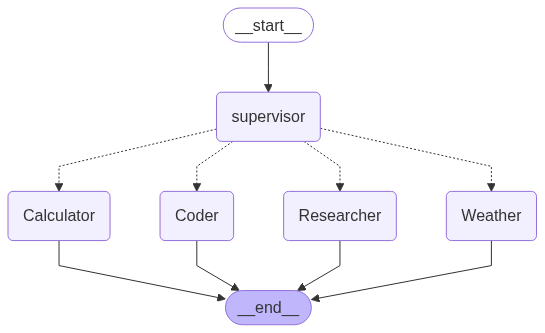

In [10]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))